In [ ]:
import os
import sys

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install datasets==2.19.0

In [ ]:
!pip install fsspec==2024.3.1

In [ ]:
!pip install evaluate==0.4.1

In [ ]:
# @title evaluate performance
import os
import cv2
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from finetune import generate_eval
from datasets import load_metric
from transformers import SamConfig, SamProcessor, SamModel
import torch

# from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

def compute_metrics(predicted_masks, true_masks, metric):
    with torch.no_grad():
        metrics = metric.compute(
            predictions=predicted_masks,
            references=true_masks,
            num_labels=2,
            ignore_index=255, #?? What is this? -Keith
            reduce_labels=False, #?? What is this? -Keith
        )
        for key, value in metrics.items():
            if isinstance(value, np.ndarray):
                metrics[key] = value.tolist()
        return metrics

def compute_iou(pred_mask, true_mask):
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def evaluate_on_images(images, true_masks, modelCheckpointFilePath):
    '''
    Parameters:
        -images a list of np arrays, where each entry in the list is the np array representation of an image
        -true_masks a list of boolean np arrays, where the ith entry represents the true mask of the ith entry in images

    Returns:
        -a list of floating point IOU values - the ith entry in the list is the IOU on image i

    '''
    assert len(images) == len(true_masks), "Length of images & masks don't match"
    predictions = generate_eval(images, modelCheckpointFilePath)
    iou_vals = [0 for _ in range(len(images))]

    for image_index in range(len(images)):
        true_mask = true_masks[image_index]
        if true_mask.ndim == 3:
            true_mask = cv2.cvtColor(true_mask, cv2.COLOR_RGB2GRAY)
        true_mask = np.reshape(true_mask, (1, true_mask.shape[0], true_mask.shape[1]))
        pred_mask =  np.reshape(predictions[image_index], (1, predictions[image_index].shape[0], predictions[image_index].shape[1]))

        intersection = np.logical_and(true_mask, pred_mask)
        union = np.logical_or(true_mask, pred_mask)
        iou = np.sum(intersection) / np.sum(union)
        iou_vals[image_index] = compute_iou(pred_mask, true_mask)

    return iou_vals


def visualize_masks(image, masks):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(image))  # Assuming the first image is grayscale
    axes[0].set_title("Image")

    # Plot the second image on the right
    axes[1].imshow(masks, cmap='gray')  # Assuming the second image is grayscale
    axes[1].set_title("Masks")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()

## example usage

"""
ious = evaluate_on_images(test_images, test_masks, "./models/base_model_checkpoint.pth")
mean_iou = sum(ious)/len(ious)
print(mean_iou)
"""

## evaluate performance on baseline model using the test dataset

'\nious = evaluate_on_images(test_images, test_masks, "./models/base_model_checkpoint.pth")\nmean_iou = sum(ious)/len(ious)\nprint(mean_iou)\n'

In [ ]:
import os
import cv2
import numpy as np
from finetune import fine_tune, generate_eval, generate_eval_segprob, reduce_masks
import random
from transformers import SamModel
import torch
import matplotlib.pyplot as plt

In [ ]:
# Define paths to images and masks folders
# Get the absolute path of the current Python script
MODE = "iris"
script_dir = os.path.dirname(".")
models_folder = os.path.join(script_dir, "models")
semi_supervised_ckpt_folder = os.path.join(models_folder, "semiSupervised")
labeled_folder = os.path.join(script_dir, "ganglion-ece661", "ganglion-ece661", "labeled")
unlabeled_folder = os.path.join(script_dir, "ganglion-ece661", "ganglion-ece661", "unlabelled")
labeled_images_folder = os.path.join(labeled_folder, "test_images")
unlabeled_images_folder = os.path.join(unlabeled_folder, "images")
masks_folder = os.path.join(labeled_folder, "masks", MODE)

labeled_image_paths = os.listdir(labeled_images_folder)
unlabeled_image_paths = os.listdir(unlabeled_images_folder)
unlabeled_image_paths = list(filter(lambda name : not (("christian_lefteye" in name) or ("cindy_lefteye" in name)), unlabeled_image_paths))
masks_paths = os.listdir(masks_folder)
random.shuffle(labeled_image_paths)
labeled_image_paths = labeled_image_paths[:100]
random.shuffle(unlabeled_image_paths)

image_path_to_image = {}
image_paths_to_add_to_training = set(unlabeled_image_paths)

def get_labeled_mask(image_name, mask_paths, mode="iris"):
    image_name = os.path.splitext(image_name)[0]
    # Load corresponding mask
    mask_filename = f"{image_name}_{mode}.png"
    if not (mask_filename in mask_paths):
        return

    mask_path = os.path.join(masks_folder, mask_filename)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        return
    return mask



# Iterate over each file in the images folder
def get_images_and_masks(image_names, get_mask, base_path=labeled_images_folder):
    global image_path_to_image
    images = []
    masks = []
    for filename in image_names:
        if (len(images) % 10 == 0):
            print(len(images))
        if filename.endswith(".jpg"):
            # Load the image
            image = None
            if filename in image_path_to_image.keys():
                image = image_path_to_image[filename]
            else:
                image_path = os.path.join(base_path, filename)
                image = cv2.imread(image_path)
                image_path_to_image[filename] = image

            if image is None:
                print(f"Error: Unable to read image {filename}")
                continue


            # Extract image name without extension
            image_name = os.path.splitext(filename)[0]

            mask = get_mask(image_name, image)
            if (mask is None):
                continue

            # Append image and mask to lists
            images.append(image)
            masks.append(mask)
    return images, masks



In [ ]:
labeled_images, labeled_masks = get_images_and_masks(labeled_image_paths, base_path=labeled_images_folder, get_mask = lambda image_path, image : get_labeled_mask(image_path, mask_paths=masks_paths , mode=MODE))


In [ ]:
unlabeled_images, _ = get_images_and_masks(unlabeled_image_paths, base_path = unlabeled_images_folder, get_mask = lambda image_Path, image : np.array([2]))


In [ ]:
def get_score_of_seg_prob_mask(seg_prob_mask):
    min = np.minimum(seg_prob_mask, 1.0 - seg_prob_mask)
    min_max = np.maximum(seg_prob_mask, min)
    return np.mean(min_max.flatten())



def get_training_data(model):
    global MODE, image_path_to_image, image_paths_to_add_to_training
    image_path_to_pred_mask = {}
    image_path_to_pred_mask_score = {}
    scores = []


    for image_name in list(image_paths_to_add_to_training)[:80]:
        if (len(scores) % 50) == 0:
            print(len(scores))
        #generate mask for each, take the top 1/3
        image = image_path_to_image[image_name]
        seg_prob_mask = generate_eval_segprob(images = [image], model=model, mode=MODE, modelCheckpointFilePath="")[0]
        score = get_score_of_seg_prob_mask(seg_prob_mask)
        image_path_to_pred_mask_score[image_name] = score
        scores.append(score)
        mask = reduce_masks([(seg_prob_mask > 0.6).astype(np.uint8)])[0]
        image_path_to_pred_mask[image_name] = mask
    scores.sort()
    threshold = scores[min(40, len(scores) - 1)]
    plt.hist(scores, bins=10)

    new_train_images = []
    new_train_masks = []
    names = list(image_paths_to_add_to_training)[:80]
    for image_name in names:
        if (image_path_to_pred_mask_score[image_name] <= threshold):
            print("chose " + image_name)
            image_paths_to_add_to_training.remove(image_name)
            new_train_images.append(image_path_to_image[image_name])
            new_train_masks.append(image_path_to_pred_mask[image_name])
    return new_train_images, new_train_masks

In [ ]:
train_images = []
train_masks = []
test_images = labeled_images
test_masks = labeled_masks


base_model_load_ckpt = os.path.join(models_folder, "iris_model_checkpoint.pth")
base_model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50")
base_model.load_state_dict(torch.load(base_model_load_ckpt))
model = base_model

In [ ]:
evaluate_on_images(images=test_images, true_masks=test_masks, modelCheckpointFilePath=base_model_load_ckpt)

In [ ]:
def visualize_a_test_mask(model):
    global test_images, test_masks, MODE
    image = np.copy(test_images[3])
    true_mask = test_masks[3]
    seg_prob_mask = generate_eval_segprob(images = [image], model=model, mode=MODE, modelCheckpointFilePath="")[0]
    pred_mask = (seg_prob_mask > 0.6).astype(np.uint8)
    mask_indices = np.where(pred_mask > 0.5)
    image[mask_indices] = [30, 30, 215]
    iou = compute_iou(pred_mask, true_mask)
    print("iou is " + str(iou))
    visualize_masks(image, pred_mask)

iou is 0.533483729410674


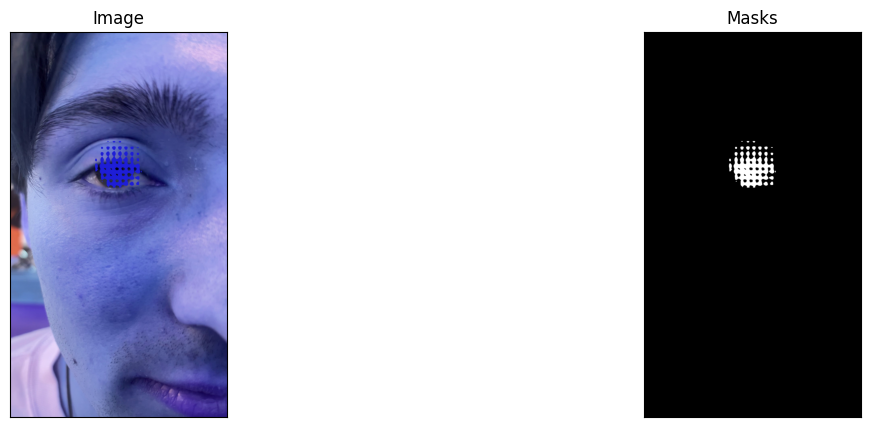

In [ ]:
visualize_a_test_mask(base_model)

#Some Time benchmarks:

time to generate_eval for one image :  ~1s
time to run through an epoch with 100 images : ~5s
time to create a dataset with 100 images : ~ 2 minutes


In [ ]:
NUM_TRAIN_SPLITS = 10
for split in range(NUM_TRAIN_SPLITS):
    print("length of training data is now " + str(len(train_images)))
    new_train_images, new_train_masks = get_training_data(model)
    #only use the masks with high confidence?
    train_images.extend(new_train_images)
    train_masks.extend(new_train_masks)
    
    model_save_ckpt = f"./models/semiSupervised_{MODE}_model_checkpoint.pth"
    fine_tune(images=train_images, pred_masks=train_masks, mode=MODE, checkpoint_info='semiSupervised', modelCheckpointFilePath = base_model_load_ckpt, BATCH_SIZE=16, num_epochs=4)
    model.load_state_dict(torch.load(model_save_ckpt))
    print("evaluating on test set")
    evaluate_on_images(images=test_images, true_masks=labeled_masks, modelCheckpointFilePath=model_save_ckpt)    
    if len(image_paths_to_add_to_training) < 20:
        break